# Problem statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## Building a simple CNN model

#### **Task 1: Reading the data**

Importing all the important libraries

In [ ]:
# Importing the required libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

You are expected to load the data in the Colab environment by mounting the Google Drive. This will allow you to access the files from Google drive through Colab. 

Steps:
1. Upload the dataset in your Google Drive in a separate folder. Avoid spaces in the name of the folder or the zip file.
2. Mount the Google Drive using the code given below.
3. Unzip the file to access images.
4. Check the path for the datasets - train and test.


Note: The code is commented for you to learn and then make edits to execute the command.

In [ ]:
## If you are using the data by mounting the google drive, use the following:
from google.colab import drive
drive.mount('/content/gdrive')

## Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [ ]:
# Your GDrive Directory
!ls /content/gdrive/MyDrive

In [ ]:
# Unzipping the files
# To do: Update the folder name and file name
# !unzip /content/gdrive/My\ Drive/folder_name/zip_file_name

Check the path mentioned in the output: `Skin cancer ISIC The International Skin Imaging Collaboration`

Provide the path for train and test images using pathlib library.

In [ ]:
# Defining the path for train and test images
## To do: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_ISIC/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_ISIC/Test')

Check whether the data has been extracted successfully.

In [ ]:
# Train and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images:\t", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:\t", image_count_test)

Train images:	 2239
Test images:	 118


#### **Task 2: Loading the images using keras.preprocessing**

The images are still not loaded in the Colab environment. We have extracted them from the zip file. Now, you are expected to load them in the Colab notebook using the `preprocessing` attribute.

Let's load these images off disk using the helpful image_dataset_from_directory utility. You can refer to the following [link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) to know more about the function. You can even refer to the additional notebooks on the page to check how the variables are defined.



Defining the parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Divide the training set into 2 parts: 
*   80% for training 
*   20% for validation



In [ ]:
## Write your code for train dataset here.
## Note: Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note: Make sure you resize your images to the size: img_height*img_width, while specifying the variable

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your code for validation dataset here.
## Note: Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note: Make sure you resize your images to the size: img_height*img_width, while specifying the variable

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the 'class_names' attribute associated with the training and validation datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### **Task 3: Visualize the data**

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

Write the code to visualize one instance of all the nine classes present in the dataset

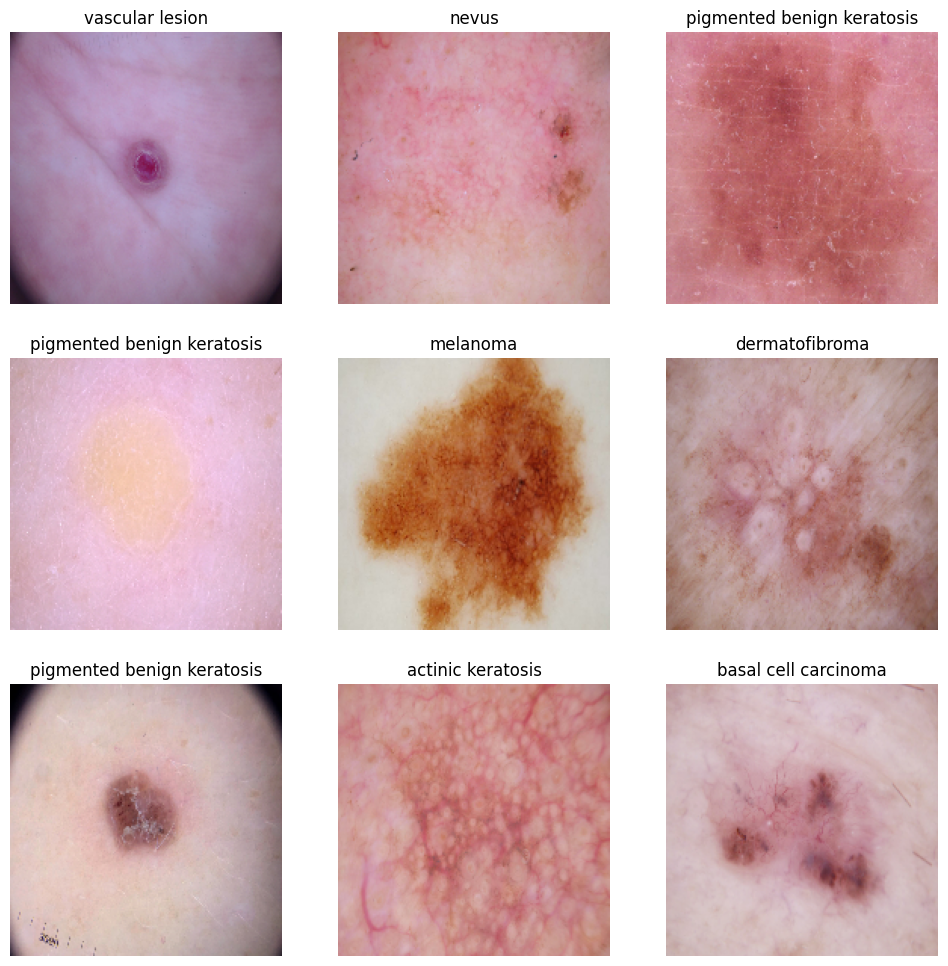

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.imshow(images[i].numpy().astype("uint8"))

#### Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Task 4: Create the model**
Create a CNN model, which can accurately detect 9 classes present in the dataset. 


*   Note: The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`. Use `layers.experimental.preprocessing.Rescaling` for this purpose.

In [ ]:
### Let's create a CNN model, which can accurately detect 9 classes present in the dataset.

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
tot_classes = 9

model1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(tot_classes)
])

#### **Question**: 
Explain the following elements associated with the problem:
1.   Selection of stride value (Reason for using a high/low value)
2.   Padding strategy used (Same/Valid)

Selection of stride value:
The stride value refers to the number of units the filter or kernel moves at each step during the convolution operation in a convolutional neural network (CNN). The selection of the stride value affects the output size and the amount of information preserved in the feature maps.
Reason for using a high value:
A high stride value (greater than 1) can be useful in downsampling the feature maps, reducing their spatial dimensions. This can be advantageous in certain cases, such as when dealing with large input data or when the computational resources are limited. High stride values can also help in extracting more generalized features by skipping some local details in the input.

Reason for using a low value:
A low stride value (equal to 1) is commonly used when the preservation of spatial information is crucial. With a low stride, the output feature maps will have the same spatial dimensions as the input, which can be important for tasks where fine-grained spatial details are significant, such as object detection or segmentation.

Padding strategy used:
Padding is the process of adding additional values around the input data before applying convolutions. It helps to preserve spatial information and mitigate the reduction in size that occurs during convolutional operations.
Same padding strategy:
Same padding refers to adding an equal number of padding elements to all sides of the input data. This means that the output feature maps will have the same spatial dimensions as the input, as long as the stride value is 1. Same padding is commonly used to maintain spatial information and ensure that the spatial resolution is preserved throughout the convolutional layers. It is especially useful when dealing with CNN architectures where skip connections or concatenations are involved.

Valid padding strategy:
Valid padding, also known as "no padding," means that no additional padding elements are added to the input data. As a result, the size of the output feature maps will be reduced compared to the input size, especially when the stride value is greater than 1. Valid padding is often used when downsampling the feature maps is desired or when the input size is already large enough to capture the relevant features without the need for additional padding.

In summary, the selection of the stride value and the padding strategy used in a CNN can impact the spatial dimensions and the amount of information preserved in the feature maps. 

#### **Task 5: Compile the model**
Choose an appropirate optimiser and loss function for model training.

In [ ]:
### Choose an appropirate optimiser and loss function
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

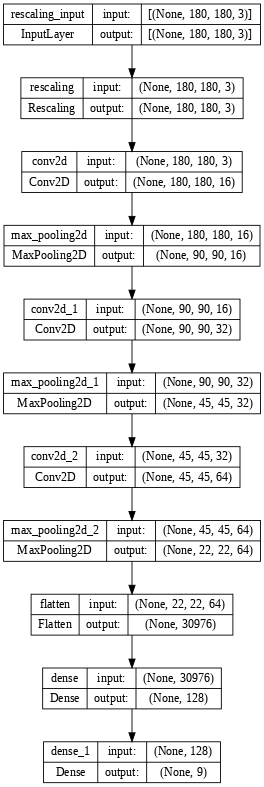

In [ ]:
tf.keras.utils.plot_model(model1, show_shapes=True, dpi=64)

#### Train the model

In [ ]:
# The model needs to be trained for 20 epochs
epochs = 20

history = model1.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs, 
)

Epoch 1/20
56/56 [==============================] - 1s 22ms/step - loss: 0.3386 - accuracy: 0.8666 - val_loss: 2.1961 - val_accuracy: 0.5391
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 0.2643 - accuracy: 0.8951 - val_loss: 2.4323 - val_accuracy: 0.5324
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 0.2600 - accuracy: 0.8895 - val_loss: 2.3849 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 0.2723 - accuracy: 0.8906 - val_loss: 2.5426 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 0.2077 - accuracy: 0.9180 - val_loss: 2.7339 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 0.1844 - accuracy: 0.9174 - val_loss: 2.4753 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 0.1666 - accuracy: 0.9291 - val_loss: 2.5966 - val_accuracy: 0.5168
Epoch 8/20
56

#### Visualizing training results

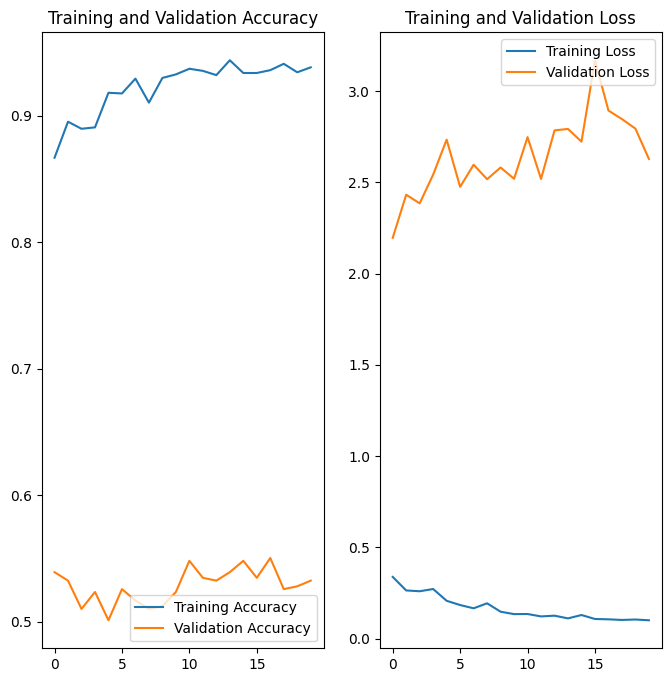

In [ ]:
# Graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Question**:
Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Findings from Model1
From the graph we can see training accuracy is very high as compared to validation accuracy. We can also see difference in loss functions in training and validation data around 19th and 20th epochs. This is a clear case of overfitting where model has learned too much from training dataset and it is not able to perform well on the validation dataset.

Training Accuracy: 93.81
Validation Accuracy: 53.24

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [ ]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times

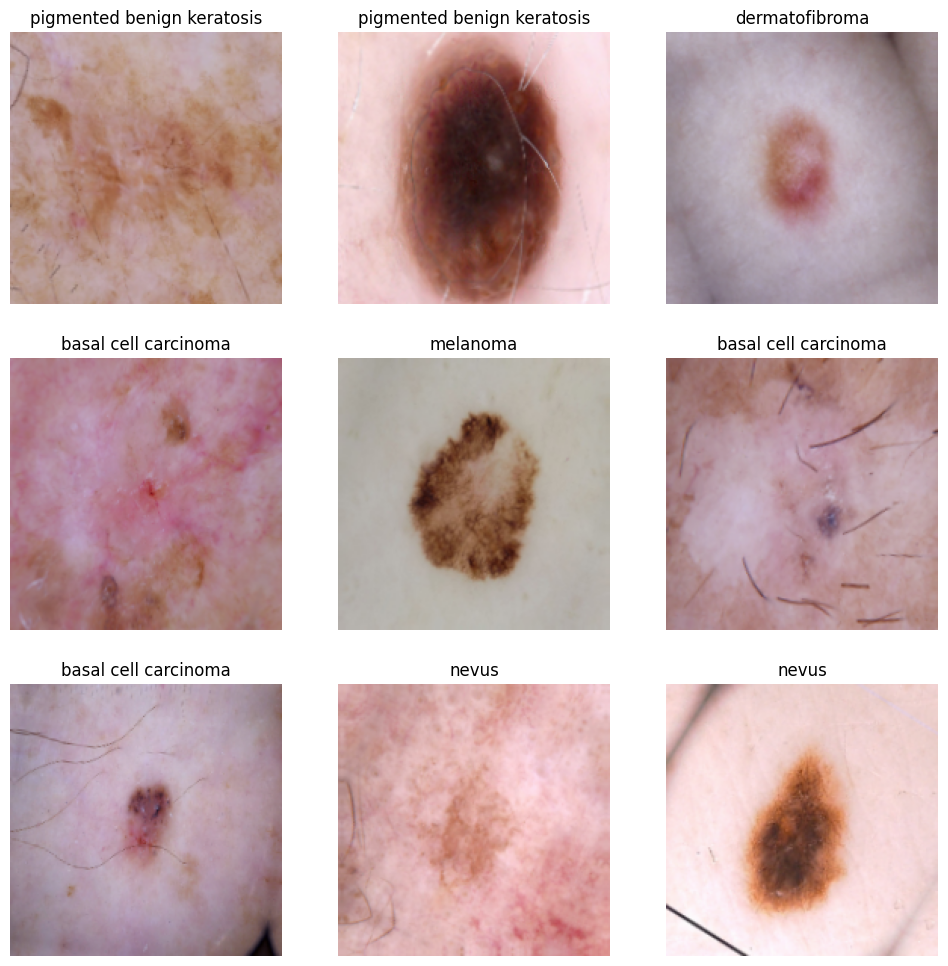

In [ ]:
# Visualizing how the augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### **Task 6: Create, compile and train the model**

Model Definition

In [ ]:
## Your code goes here
## You should also include dropouts to tackle with overfitting. (compulsory)

## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

model2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(tot_classes)
])


Compiling the model

In [ ]:
## Your code goes here
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

In [ ]:
# Note: Train your model for 30 epochs
## Your code goes here

epochs=20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 34ms/step - loss: 2.1422 - accuracy: 0.2042 - val_loss: 1.9610 - val_accuracy: 0.2438
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.8434 - accuracy: 0.3432 - val_loss: 1.7303 - val_accuracy: 0.4049
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5746 - accuracy: 0.4475 - val_loss: 1.6406 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4553 - accuracy: 0.5033 - val_loss: 1.4855 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4468 - accuracy: 0.4933 - val_loss: 1.4525 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4203 - accuracy: 0.4994 - val_loss: 1.4031 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3775 - accuracy: 0.5156 - val_loss: 1.4870 - val_accuracy: 0.4855
Epoch 8/20
56

#### Visualizing the results

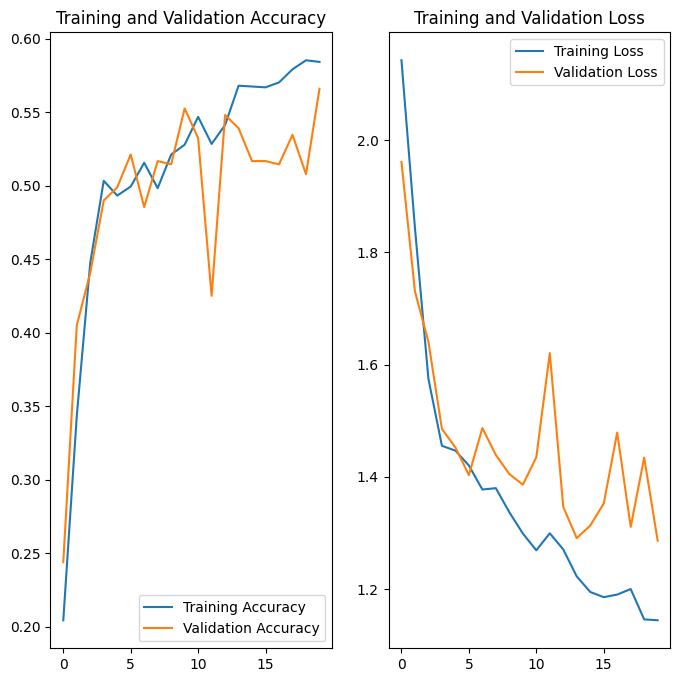

In [ ]:
# Graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Question**:
Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Findings from Model 2
Accuracy of trainings has not improved as compared to base model but gap between training accuracy and validation accuracy is reduced. Also validation accuracy is increased slightly compared to base model. Gap between loss of training and validation is also reduced. And we observe that overfitting issue has been reduced due to data augmentation.

Training Accuracy: 58.43
Validation Accuracy: 56.60

## Distribution in the dataset

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<br>

#### **Task 7: Find the distribution of classes in the training dataset.**

In [ ]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,vascular lesion
2235,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,vascular lesion
2236,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,vascular lesion
2237,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,vascular lesion


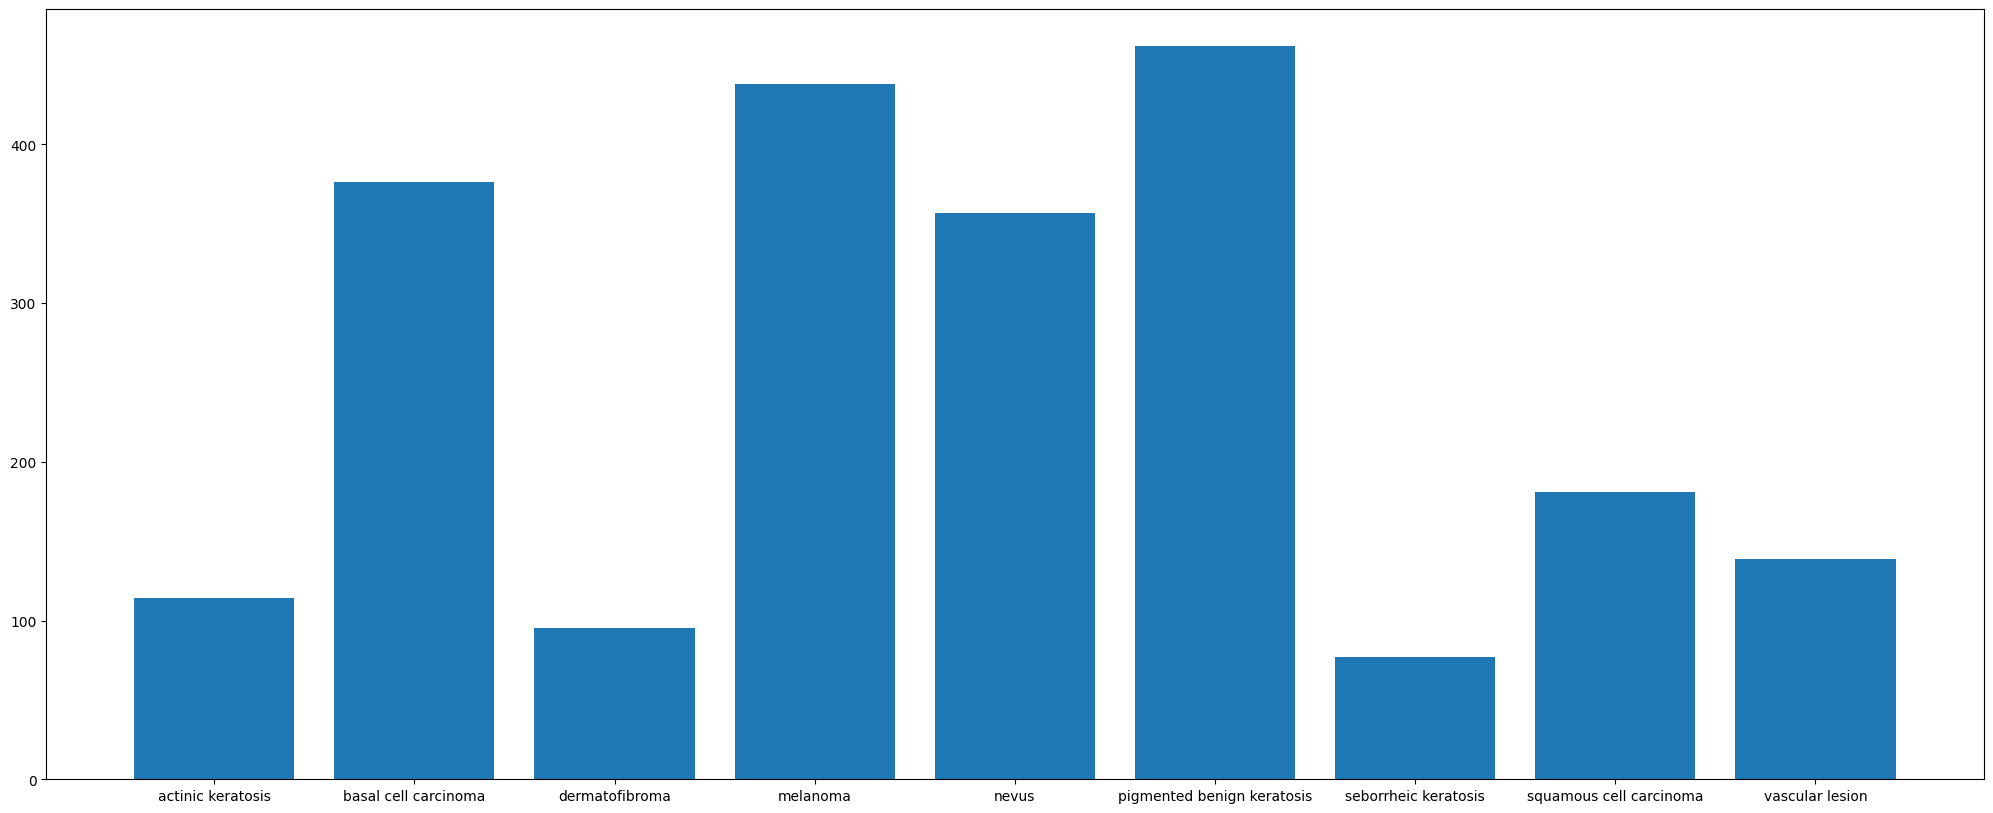

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)
plt.show()

#### **Questions:**  
 - Which class has the least number of samples?
 - Which classes dominate the data in terms proportionate number of samples?


Seborrheic Keratosis have least number of samples

Pigmented Benign keratosis classes dominate the data in terms proportionate number of samples.

#### **Task 8: Rectifying the class imbalance**
You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
# Provide the path for the training dataset
path_to_training_dataset=str("/content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train")+ '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)
    ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1792242B60>: 100%|██████████| 500/500 [00:21<00:00, 23.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F185F0157E0>: 100%|██████████| 500/500 [00:21<00:00, 23.10 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1792201FF0>: 100%|██████████| 500/500 [00:20<00:00, 24.10 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F17A89749D0>: 100%|██████████| 500/500 [01:46<00:00,  4.69 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F179236C910>: 100%|██████████| 500/500 [01:41<00:00,  4.93 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F17920E7CA0>: 100%|██████████| 500/500 [00:22<00:00, 22.49 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F17A8975E70>: 100%|██████████| 500/500 [00:46<00:00, 10.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F17921E3F10>: 100%|██████████| 500/500 [00:20<00:00, 24.58 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1792287280>: 100%|██████████| 500/500 [00:22<00:00, 22.26 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [39]:
# Count of images under each class after addition
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train")
image_count_train1 = len(list(data_dir_train1.glob('*/output/*.jpg')))
print(image_count_train1)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,actinic keratosis
...,...,...
4473,/content/gdrive/MyDrive/Colab_Notebooks/Skin_c...,vascular lesion
4474,/content/gdrive/MyDrive/Colab_Notebooks/Skin_c...,vascular lesion
4475,/content/gdrive/MyDrive/Colab_Notebooks/Skin_c...,vascular lesion
4476,/content/gdrive/MyDrive/Colab_Notebooks/Skin_c...,vascular lesion


In [41]:
new_df['Label'].value_counts()

pigmented benign keratosis    924
melanoma                      876
basal cell carcinoma          752
nevus                         714
squamous cell carcinoma       362
vascular lesion               278
actinic keratosis             228
dermatofibroma                190
seborrheic keratosis          154
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### **Task 9: Repeating the steps for balanced augmented data**

In [42]:
batch_size = 32
img_height = 180
img_width = 180

**Create a training dataset**

In [43]:
import pathlib
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train")

In [44]:
data_dir_train1

PosixPath('/content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train')

In [45]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2239


In [46]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Colab_Notebooks/Skin_cancer_ISIC/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Create a validation dataset**

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Create your model (make sure to include normalization)**

In [48]:
## Your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model3 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(tot_classes)
])

**Compile your model (Choose optimizer and loss function appropriately)**

In [50]:
## Your code goes here
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Train your model**

In [56]:
# Note: Train your model for 30 epochs
## Your code goes here

epochs =30
## Your code goes here, use 50 epochs.
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 4s 25ms/step - loss: 0.1485 - accuracy: 0.9444 - val_loss: 1.2182 - val_accuracy: 0.7758
Epoch 2/30
169/169 [==============================] - 4s 25ms/step - loss: 0.1407 - accuracy: 0.9455 - val_loss: 1.2237 - val_accuracy: 0.7706
Epoch 3/30
169/169 [==============================] - 4s 25ms/step - loss: 0.0947 - accuracy: 0.9562 - val_loss: 1.1546 - val_accuracy: 0.8018
Epoch 4/30
169/169 [==============================] - 4s 25ms/step - loss: 0.0841 - accuracy: 0.9622 - val_loss: 1.2100 - val_accuracy: 0.8099
Epoch 5/30
169/169 [==============================] - 4s 25ms/step - loss: 0.1058 - accuracy: 0.9536 - val_loss: 0.9687 - val_accuracy: 0.8122
Epoch 6/30
169/169 [==============================] - 4s 26ms/step - loss: 0.0768 - accuracy: 0.9646 - val_loss: 1.0982 - val_accuracy: 0.8048
Epoch 7/30
169/169 [==============================] - 4s 25ms/step - loss: 0.1415 - accuracy: 0.9455 - val_loss: 1.1817 - val_accuracy: 0.7788

**Visualize the model results**

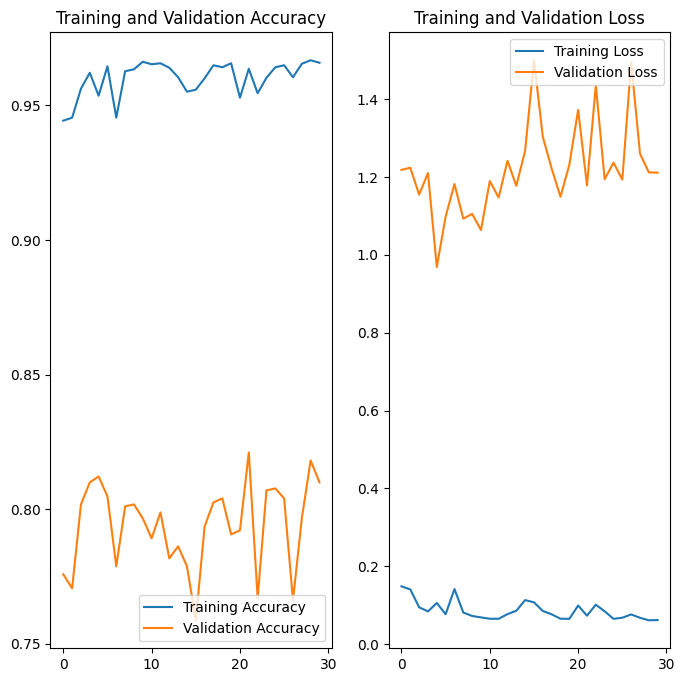

In [58]:
# Graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Task 10: Analyzing the results** 


#### **Question:**
- Did you get rid of underfitting/overfitting from the model? 
- Did class rebalance help in the process?


Findings from Model 3
Accuracy of training and validation has been increased significantly due to augmentation and class imbalnce handling. The model is not overfitting. This model can be used as final model.

Training Accuracy: 96.68
Validation Accuracy: 81.81